# Cross Entropy Method for MountainCar environment


https://gym.openai.com/envs/MountainCar-v0/

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Number of states: (2,)
Number of actions: 3


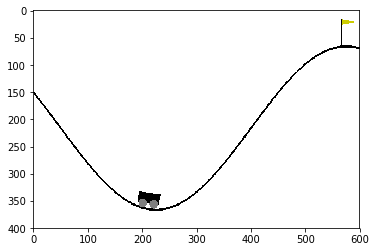

In [22]:
import time
import gym
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import sklearn.neural_network as nn
from sklearn import preprocessing
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)


env = gym.make("MountainCar-v0").env
env.reset()
print('Number of states: {}'.format(env.observation_space.shape))
print('Number of actions: {}'.format(env.action_space.n))

plt.imshow(env.render("rgb_array"))

In [2]:
class Agent():
    
    def __init__(self, env):
        self.n_spaces = env.observation_space.shape
        self.n_actions = env.action_space.n
        self.model = self.build_model()
        self.action_encoder = preprocessing.OneHotEncoder(self.n_actions)
        self.action_encoder.fit(np.arange(self.n_actions).reshape(-1, 1))
        self.init_model()
        
    def build_model(self):
        model = nn.MLPClassifier(hidden_layer_sizes=(20,20), activation='tanh', warm_start=True, max_iter=1)
        return model
    
    def init_model(self):
        states = np.array([env.reset()]*self.n_actions)
        actions = np.arange(self.n_actions)
        self.update(states, actions)

    def policy(self, state):
        probs = self.model.predict(np.array([state]))
        return np.argmax(probs)
        
    def update(self, states, actions):
        encoded_actions = self.action_encoder.transform(actions.reshape(-1, 1))
        self.model.fit(states, encoded_actions)
    

agent = Agent(env)
agent.policy(env.reset())

0

In [3]:
def generate_session(agent, t_max=1000):
    
    states,actions = [],[]
    total_reward = 0
    
    s = env.reset()
    
    for t in range(t_max):
        
        a = agent.policy(s)
        
        new_s, r, done, info = env.step(a)
        
        #record sessions
        states.append(s)
        actions.append(a)
        total_reward += r
        
        s = new_s
        if done: break
            
    return states, actions, total_reward
        

In [4]:
s, a, r = generate_session(agent)
assert type(s) == type(a) == list
assert len(s) == len(a)
assert type(r) in [float,np.float]
print('Steps={}, reward={}, max_right={}'.format(len(s), r, np.max(s, axis=0)[0]))
print("Ok!")

Steps=1000, reward=-1000.0, max_right=-0.4561218808879029
Ok!


### CEM steps
Deep CEM uses exactly the same strategy as the regular CEM, so you can copy your function code from previous notebook.

The only difference is that now each observation is not a number but a float32 vector.

In [20]:
def select_elites(states_batch, actions_batch, rewards_batch, percentile=50):
    """
    Select states and actions from games that have rewards >= percentile
    :param states_batch: list of lists of states, states_batch[session_i][t]
    :param actions_batch: list of lists of actions, actions_batch[session_i][t]
    :param rewards_batch: list of rewards, rewards_batch[session_i][t]
    
    :returns: elite_states,elite_actions, both 1D lists of states and respective actions from elite sessions
    
    Please return elite states and actions in their original order 
    [i.e. sorted by session number and timestep within session]
    
    If you're confused, see examples below. Please don't assume that states are integers (they'll get different later).
    """
    
    xs = map(np.max)
    reward_threshold = np.percentile(rewards_batch, percentile)
    elites = rewards_batch > reward_threshold
    
    
    elite_states  = []
    elite_actions = []
    for i, v in enumerate(elites):
        if v:
            elite_states += states_batch[i]
            elite_actions += actions_batch[i]
    
    return elite_states, elite_actions
    

In [9]:
states_batch = [
    [[1, 1],[2, 2],[3, 3]],          #game1
    [[4, 4], [2, 2], [0, 3], [2,2]], #game2
    [[3,1],[1,3]]                    #game3
]

actions_batch = [
    [0,2,4],   #game1
    [3,2,0,1], #game2
    [3,3]      #game3
]
rewards_batch = [
    3,         #game1
    4,         #game2
    5,         #game3
]

test_result = select_elites(states_batch, actions_batch, rewards_batch, percentile=90)
assert np.all(test_result[0] == [[3, 1], [1, 3]]) and \
        np.all(test_result[1] == [3,3]),\
        "For percentile 90 you should only select states/actions from one game"
select_elites(states_batch, actions_batch, rewards_batch, percentile=0)
print("Ok!")

Ok!


# Training loop
Generate sessions, select N best and fit to those.

In [10]:
from IPython.display import clear_output

def show_progress(step, batch_rewards, log, percentile, reward_range=[-990,+10]):
    """
    A convenience function that displays training progress. 
    No cool math here, just charts.
    """
    
    mean_reward, max_reward = np.mean(batch_rewards), np.max(batch_rewards)
    threshold = np.percentile(batch_rewards, percentile)
    log.append([mean_reward, threshold])

    clear_output(True)
    print("Step: %d, mean reward = %.3f, threshold=%.3f, max=%.3f" % (step, mean_reward, threshold, max_reward))
    plt.figure(figsize=[8,4])
    plt.subplot(1,2,1)
    plt.plot(list(zip(*log))[0], label='Mean rewards')
    plt.plot(list(zip(*log))[1], label='Reward thresholds')
    plt.legend()
    plt.grid()
    
    plt.subplot(1,2,2)
    plt.hist(batch_rewards, range=reward_range);
    plt.vlines([np.percentile(batch_rewards, percentile)], [0], [100], label="percentile", color='red')
    plt.legend()
    plt.grid()

    plt.show()


Step: 91, mean reward = -10000.000, threshold=-10000.000, max=-10000.000


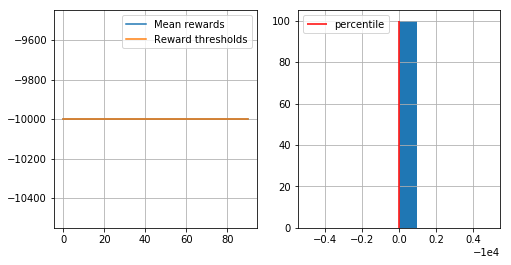

KeyboardInterrupt: 

In [26]:
n_sessions = 100
percentile = 80
log = []
max_steps = 500

agent = Agent(env)

for i in range(100):
    
    sessions = [generate_session(agent, t_max=max_steps) for _ in range(n_sessions)]

    batch_states,batch_actions,batch_rewards = zip(*sessions)

    elite_states, elite_actions = select_elites(batch_states, batch_actions, batch_rewards, percentile=percentile)
    
    if len(elite_actions) > 0:
        states = np.array(elite_states)
        actions = np.array(elite_actions)
        agent.update(states, actions)

    show_progress(i+1, batch_rewards, log, percentile, reward_range=[-max_steps, np.max(batch_rewards)])
    
    if np.mean(batch_rewards)> 190:
        print("You Win! in {} steps".format(i+1))
        break

# Results